In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import logging
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dask.distributed import Client
from replay_trajectory_classification import (
    SortedSpikesDecoder,
    ClusterlessDecoder,
)

from src.figure_utilities import (
    PAGE_HEIGHT,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import STATE_COLORS, TRANSITION_TO_CATEGORY

set_figure_defaults()

In [3]:
epoch_key = "remy", 35, 4
ripple_number = 93

In [4]:
from src.load_data import load_data

data = load_data(epoch_key)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO35.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO35.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO35.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO35.mat
No DIO file found, inferring correct inbound/outbound from task rules


In [5]:
from loren_frank_data_processing import (
    get_multiunit_dataframe2,
    get_spikes_dataframe,
    make_neuron_dataframe,
)
from src.parameters import ANIMALS, _BRAIN_AREAS

multiunit_times = [
    get_multiunit_dataframe2(tetrode_key, ANIMALS)
    for tetrode_key in data["tetrode_info"].index
]

In [6]:
from src.parameters import (
    ANIMALS,
    FIGURE_DIR,
    PROBABILITY_THRESHOLD,
    PROCESSED_DATA_DIR,
    SAMPLING_FREQUENCY,
    TRANSITION_TO_CATEGORY,
    continuous_transition_types,
    discrete_diag,
    knot_spacing,
    model,
    model_kwargs,
    movement_var,
    place_bin_size,
    replay_speed,
    spike_model_penalty,
)

from loren_frank_data_processing.position import (
    make_track_graph,
    EDGE_ORDER,
    EDGE_SPACING,
)


is_training = data["position_info"].speed > 4
position = data["position_info"].loc[:, "linear_position"]
track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

classifier = ClusterlessDecoder(
    place_bin_size=place_bin_size,
    movement_var=movement_var,
    replay_speed=replay_speed,
    model=model,
    model_kwargs=model_kwargs,
)
classifier.fit(
    position,
    data["multiunit"],
    is_training=is_training,
    track_graph=track_graph,
    center_well_id=center_well_id,
    edge_order=EDGE_ORDER,
    edge_spacing=EDGE_SPACING,
)

ClusterlessDecoder(infer_track_interior=True,
                   initial_conditions_type='uniform_on_track',
                   model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                   model_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                   movement_var=6.0,
                   occupancy_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                   occupancy_model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                   place_bin_size=3.0, position_range=None, replay_speed=1,
                   transition_type='random_walk')

In [7]:
time_slice = slice(*data["ripple_times"].loc[ripple_number, ["start_time", "end_time"]])
m = data["multiunit"].sel(time=time_slice)

results_1D = classifier.predict(m, m.time - m.time[0])

In [8]:
results_1D

<xarray.Dataset>
Dimensions:            (position: 109, time: 147)
Coordinates:
  * time               (time) timedelta64[ns] 00:00:00 ... 00:00:00.292000
  * position           (position) float64 1.464 4.391 7.319 ... 338.4 341.3
Data variables:
    likelihood         (time, position) float64 0.6915 0.6584 ... 0.04918
    causal_posterior   (time, position) float64 0.01135 0.01081 ... 1.201e-23
    acausal_posterior  (time, position) float64 1.58e-14 2.043e-14 ... 1.201e-23

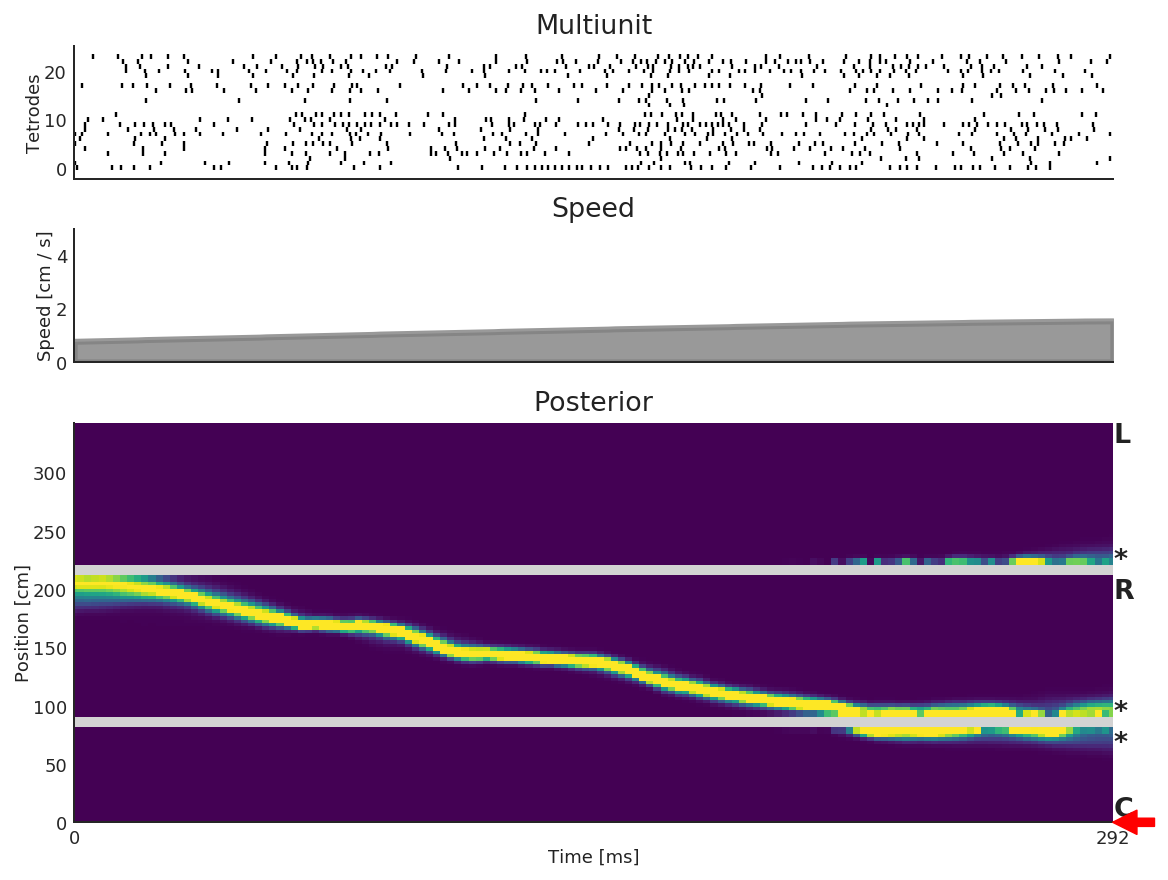

In [44]:
position = data["position_info"].loc[:, "linear_position"]
ripple_start, ripple_end = (
    data["ripple_times"].loc[ripple_number].start_time,
    data["ripple_times"].loc[ripple_number].end_time,
)
time_slice = slice(*data["ripple_times"].loc[ripple_number, ["start_time", "end_time"]])

fig, axes = plt.subplots(
    3,
    1,
    sharex=True,
    constrained_layout=True,
    figsize=(8, 6),
    gridspec_kw={"height_ratios": [1, 1, 3]},
)


n_tetrodes = len(multiunit_times)

MILLISECONDS_TO_SECONDS = 1000

axes[0].eventplot(
    [
        MILLISECONDS_TO_SECONDS
        * (multiunit.loc[ripple_start:ripple_end].index - ripple_start)
        / np.timedelta64(1, "s")
        for multiunit in multiunit_times
    ],
    color="black",
)

axes[0].set_xlim(
    (0, MILLISECONDS_TO_SECONDS * (ripple_end - ripple_start) / np.timedelta64(1, "s"))
)
axes[0].set_xticks(
    (0, MILLISECONDS_TO_SECONDS * (ripple_end - ripple_start) / np.timedelta64(1, "s"))
)
axes[0].set_title("Multiunit")
axes[0].set_ylabel("Tetrodes")

cmap = copy.copy(plt.cm.get_cmap("viridis"))
cmap.set_bad(color="lightgrey", alpha=1.0)

(
    results_1D.assign_coords(
        time=lambda ds: MILLISECONDS_TO_SECONDS * ds.time / np.timedelta64(1, "s")
    )
    .acausal_posterior.where(classifier.is_track_interior_)
    .plot(
        x="time",
        y="position",
        robust=True,
        add_colorbar=False,
        zorder=0,
        rasterized=True,
        cmap=cmap,
    )
)

t = (
    (data["position_info"].loc[ripple_start:ripple_end].index - ripple_start)
    / np.timedelta64(1, "s")
    * MILLISECONDS_TO_SECONDS
)
axes[1].fill_between(
    t,
    data["position_info"].loc[ripple_start:ripple_end, "speed"],
    color="grey",
    facecolor="lightgrey",
    alpha=0.8,
    linewidth=3,
)
axes[1].set_ylabel("Speed [cm / s]")
axes[1].set_ylim((0, 5))
axes[1].set_title("Speed")

ripple_position = (
    data["position_info"].loc[ripple_start:ripple_end, "linear_position"].mean()
)
ripple_duration = (
    MILLISECONDS_TO_SECONDS
    * (time_slice.stop - time_slice.start)
    / np.timedelta64(1, "s")
)
max_time = (
    MILLISECONDS_TO_SECONDS * results_1D.time.values / np.timedelta64(1, "s")
).max()
axes[2].annotate(
    "",
    xy=(max_time, ripple_position),
    xycoords="data",
    xytext=(max_time + ripple_duration * 0.04, ripple_position),
    textcoords="data",
    arrowprops=dict(shrink=0.00, color="red"),
    horizontalalignment="left",
    verticalalignment="center",
    color="red",
    zorder=200,
)
axes[2].set_xlim((0, max_time))
axes[2].set_xticks(
    (0, MILLISECONDS_TO_SECONDS * (ripple_end - ripple_start) / np.timedelta64(1, "s"))
)
axes[2].set_xlabel("Time [ms]")
axes[2].set_title("Posterior")

arm_min_max = (
    data["position_info"].groupby("arm_name").linear_position.aggregate(["min", "max"])
)
axes[2].text(
    max_time + 0.1,
    arm_min_max.loc["Center Arm", "min"],
    "C",
    ha="left",
    va="bottom",
    weight="bold",
)
axes[2].text(
    max_time + 0.1,
    arm_min_max.loc["Center Arm", "max"],
    "*",
    ha="left",
    va="top",
    weight="bold",
)
axes[2].text(
    max_time + 0.1,
    arm_min_max.loc["Right Arm", "max"],
    "R",
    ha="left",
    va="top",
    weight="bold",
)
axes[2].text(
    max_time + 0.1,
    arm_min_max.loc["Right Arm", "min"],
    "*",
    ha="left",
    va="center",
    weight="bold",
)
axes[2].text(
    max_time + 0.1,
    arm_min_max.loc["Left Arm", "max"],
    "L",
    ha="left",
    va="top",
    weight="bold",
)
axes[2].text(
    max_time + 0.1,
    arm_min_max.loc["Left Arm", "min"],
    "*",
    ha="left",
    va="center",
    weight="bold",
)
axes[2].set_ylabel("Position [cm]")

sns.despine()

plt.savefig("demetris_figure.pdf", transparent=True, dpi=300, bbox_inches="tight")